In [2]:
import os
import io
import time
import pickle
import scipy
import pandas as pd
import numpy as np

import cv2
from skimage import transform
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import autocast, GradScaler

from Datasets import *


image_dir = r"I:\AVA_images"
csv_dir = r"C:\Users\Leo's PC\Desktop\AVA.txt"
checkpoint_save_dir = r"I:\Model Checkpoints"

### Dangerous

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Create Dataset Instances and DataLoaders

index = 0 AVA Dataset initialization begin...
Rating distribution initialized:  []
4.578947368421052


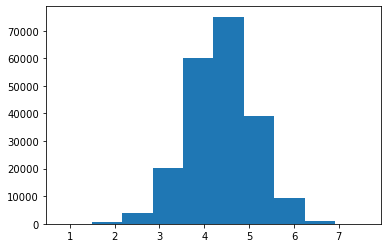

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



index = 0 AVA Dataset initialization begin...
Rating distribution initialized:  []
4.372413793103449


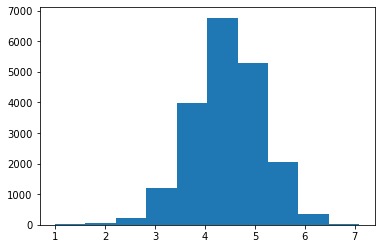

AVA Dataset initialization complete. Rating distribution is:  [4.372413793103449, 3.7739726027397262, 4.732394366197183, 4.534246575342466, 4.739726027397261, 4.097222222222222, 5.143884892086331, 4.910958904109589, 5.040816326530612, 4.806666666666667, 4.638297872340425, 4.456375838926174, 6.019607843137255, 4.8321678321678325, 4.838028169014085, 5.212328767123288, 4.401360544217687, 4.386206896551724, 5.103448275862069, 4.366197183098592, 4.176470588235294, 3.906474820143885, 4.847222222222222, 4.878378378378378, 5.201342281879195, 4.959731543624161, 4.251748251748252, 3.9510489510489513, 4.576388888888889, 4.7534246575342465, 5.035211267605634, 4.444444444444445, 4.895104895104895, 5.453900709219858, 3.9295774647887325, 5.097222222222222, 4.966216216216216, 5.178807947019868, 4.251655629139073, 4.618055555555555, 4.580419580419581, 4.542857142857143, 4.358108108108108, 5.054794520547945, 5.299319727891157, 5.006711409395973, 4.807142857142857, 4.085106382978723, 5.8618421052631575, 

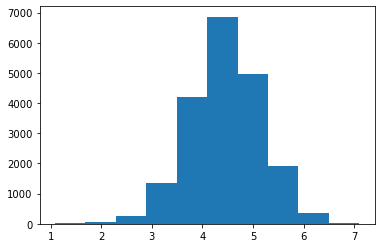

AVA Dataset initialization complete. Rating distribution is:  [4.814207650273224, 4.389473684210526, 4.321243523316062, 4.634831460674158, 4.360655737704918, 3.9732620320855614, 4.69109947643979, 5.13903743315508, 4.683060109289618, 4.695652173913044, 4.9289617486338795, 4.263736263736264, 5.240641711229946, 5.224043715846994, 4.167567567567567, 4.554945054945055, 4.052356020942408, 3.9945945945945946, 4.751351351351351, 4.022857142857143, 2.6, 3.978609625668449, 3.7925531914893615, 5.396907216494846, 5.276923076923077, 3.7666666666666666, 4.809782608695652, 4.6378378378378375, 4.867021276595745, 4.142045454545454, 3.3369565217391304, 4.387978142076503, 4.136612021857924, 3.9206349206349205, 5.076086956521739, 4.551351351351351, 4.247252747252747, 3.4804469273743015, 4.459016393442623, 4.935828877005347, 4.639784946236559, 5.636363636363637, 4.355191256830601, 4.518324607329843, 4.672043010752688, 4.240641711229946, 3.8095238095238093, 4.236559139784946, 3.652173913043478, 5.0793650793

In [3]:
AVA_Train = AVADataset(csv_file=csv_dir, file_dir=image_dir, start=0, end=209999, 
                       transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))
AVA_Validation = AVADataset(csv_file=csv_dir, file_dir=image_dir, start=210000, end=229999, 
                            transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))
AVA_Test = AVADataset(csv_file=csv_dir, file_dir=image_dir, start=230000, end=249999, transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))

index = 0 AVA Dataset initialization begin...
Rating distribution initialized:  [0 0]
csv_idx: 10000 index: 1259 img_name 758229 avg_rat -1 
  - Current rating distribution is:  [1018  241]
csv_idx: 20000 index: 2284 img_name 451851 avg_rat -1 
  - Current rating distribution is:  [1809  475]
csv_idx: 30000 index: 3305 img_name 348334 avg_rat -1 
  - Current rating distribution is:  [2611  694]
csv_idx: 40000 index: 4562 img_name 584770 avg_rat -1 
  - Current rating distribution is:  [3678  884]
csv_idx: 50000 index: 5873 img_name 324746 avg_rat 0 
  - Current rating distribution is:  [4795 1078]
csv_idx: 60000 index: 7135 img_name 527494 avg_rat -1 
  - Current rating distribution is:  [5792 1343]
csv_idx: 70000 index: 8169 img_name 682519 avg_rat -1 
  - Current rating distribution is:  [6541 1628]
csv_idx: 80000 index: 9155 img_name 517426 avg_rat -1 
  - Current rating distribution is:  [7291 1864]
csv_idx: 90000 index: 9713 img_name 776483 avg_rat -1 
  - Current rating distribut

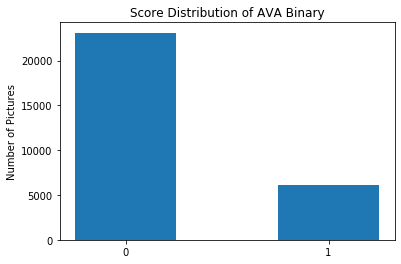

Stage 2 begin. Target class size is: 25000 Distribution multiplier is: [2. 5.]
AVA Dataset initialization complete. Rating distribution is:  [25004 25000] 
 contains 50004 items.


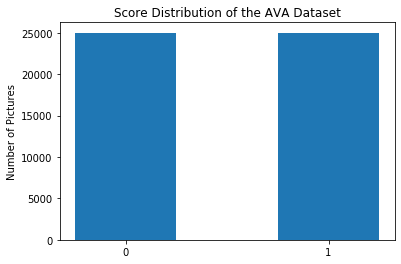

'\nAVABinary_Validation = AVABinaryDataset(csv_file=csv_dir, file_dir=image_dir, start=210000, end=229999, \n                            transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))\nAVABinary_Test = AVABinaryDataset(csv_file=csv_dir, file_dir=image_dir, start=230000, end=249999, \n                      transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))\n'

In [75]:
AVABinary_Train = AVABinaryDataset(csv_file=csv_dir, file_dir=image_dir, start=0, end=209999, class_size=25000,
                       transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))
'''
AVABinary_Validation = AVABinaryDataset(csv_file=csv_dir, file_dir=image_dir, start=210000, end=229999, 
                            transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))
AVABinary_Test = AVABinaryDataset(csv_file=csv_dir, file_dir=image_dir, start=230000, end=249999, 
                      transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))
'''

209999 images are found within the specified range
Extremes: ('7143', 0.8089887640449438) ('9482', 7.571428571428571)
104999 images with label 0. 105000 images with label 1.


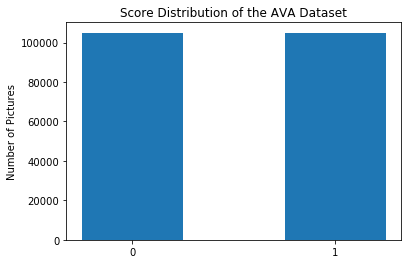

19999 images are found within the specified range
Extremes: ('104023', 1.0037735849056604) ('106', 7.6)
9999 images with label 0. 10000 images with label 1.


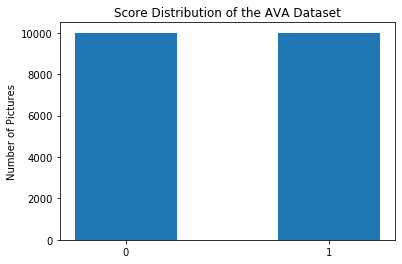

19999 images are found within the specified range
Extremes: ('17640', 1.1810344827586208) ('491369', 7.399253731343284)
9999 images with label 0. 10000 images with label 1.


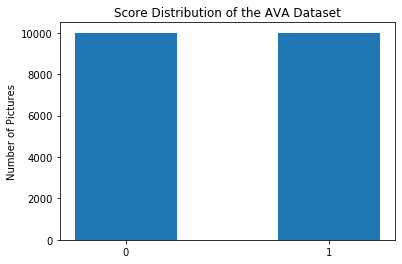

In [3]:
Train = AVABinaryDataset_ten(csv_file=csv_dir, file_dir=image_dir, start=0, end=209999, percent=0.5,
                             transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))

Validation = AVABinaryDataset_ten(csv_file=csv_dir, file_dir=image_dir, start=210000, end=229999, percent=0.5,
                             transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))

Test = AVABinaryDataset_ten(csv_file=csv_dir, file_dir=image_dir, start=230000, end=249999, percent=0.5,
                             transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))

8458 images found in image dir
8458 entries found in the CSV file
index = 0 AADB Dataset initialization begin...
Rating distribution initialized:  [0 0 0 0 0 0 0 0 0 0]
csv_idx: 0 index: 1 img_name farm1_333_19438364933_087c8abc60_b.jpg avg_rat 0.3 
  - Current rating distribution is:  [0 0 1 0 0 0 0 0 0 0]
csv_idx: 1000 index: 853 img_name farm1_298_20320093382_66a41f1f31_b.jpg avg_rat 0.6 
  - Current rating distribution is:  [ 25  53 126 155 173 158 100  40  14   9]
csv_idx: 2000 index: 1696 img_name farm1_332_19802506768_41e221b57b_b.jpg avg_rat 0.6 
  - Current rating distribution is:  [ 42 105 238 291 353 322 209  79  32  25]
csv_idx: 5000 index: 4235 img_name farm1_322_19882036329_81c743894b_b.jpg avg_rat 0.7 
  - Current rating distribution is:  [ 95 251 590 747 882 808 492 236  71  63]
csv_idx: 6000 index: 5107 img_name farm1_335_20208755131_aedbb86b2a_b.jpg avg_rat 0.5 
  - Current rating distribution is:  [ 122  313  714  918 1060  954  582  279   87   78]
csv_idx: 8000 inde

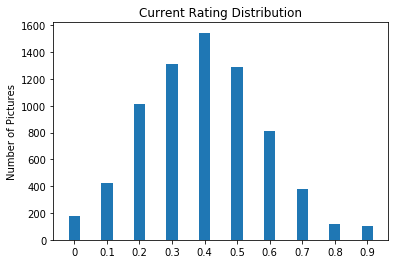

AADB Dataset initialization complete. Rating distribution is:  [ 175  421 1010 1308 1545 1288  811  381  115  106] 
 contains 7160 items.


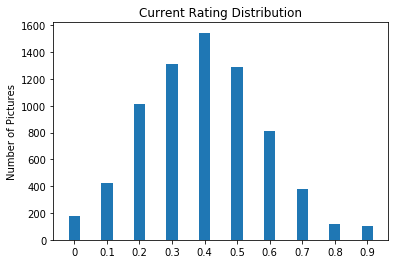

In [23]:
AADB_Train = AADBDataset(csv_file=r'H:\AADB\imgListTrainRegression_score.csv', file_dir=r'H:\AADB\train', start=0, end=8458,
                        transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))

#### save dataset objects as pkl

In [6]:
with open('./AVA_dataset_pkl/AVA_Linear_imbalanced_average_train.pkl', 'wb') as fp:
    pickle.dump(AVA_Train, fp)

#### load dataset pkl

In [4]:
with open('I:\AVA_dataset_pkl/train_10%_binary.pkl', 'rb') as fp:
    Train = pickle.load(fp)
    
with open('I:\AVA_dataset_pkl/validation_10%_binary.pkl', 'rb') as fp:
    Validation = pickle.load(fp)

with open('I:\AVA_dataset_pkl/test_10%_binary.pkl', 'rb') as fp:
    Test = pickle.load(fp)

In [5]:
batch_size = 32

train_loader = DataLoader(dataset=Train, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=Validation, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=Test, batch_size=batch_size, shuffle=False)

In [6]:
print(len(next(enumerate(train_loader))))

2


# Model Class

In [7]:
class FeatureNet(nn.Module):
    def __init__(self):
        super(FeatureNet, self).__init__()
        
        self.densenet = torchvision.models.densenet121(pretrained=True, progress=True).features

        self.dense_input = nn.Sequential(self.densenet.conv0, self.densenet.norm0, self.densenet.relu0, self.densenet.pool0)
        self.dense_block1 = self.densenet.denseblock1
        self.dense_block2 = self.densenet.denseblock2
        self.dense_block3 = self.densenet.denseblock3
        self.dense_block4 = self.densenet.denseblock4
        
        self.dense_transition1 = self.densenet.transition1 
        self.dense_transition2 = self.densenet.transition2 
        self.dense_transition3 = self.densenet.transition3 

        self.pooling = nn.AvgPool2d(kernel_size = [7, 7], stride=7, padding=0)
        self.classifier = nn.Linear(1024, 2)
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    @autocast()
    def forward(self, x):
        x = self.dense_input(x)
        x = self.dense_block1(x)
        x = self.dense_transition1(x)
        x = self.dense_block2(x)
        x = self.dense_transition2(x)
        x = self.dense_block3(x)
        x = self.dense_transition3(x)
        x = self.dense_block4(x)
        x = self.pooling(x)
        
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        # x = self.sigmoid(x)
        x= self.softmax(x)
        return x

    def name(self):
        return "FeatureNet"

# Model Initialization & Hyperparameters

In [8]:
model = FeatureNet()

In [9]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0001, betas=(0.9, 0.999))
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

In [10]:
for p in model.dense_input.parameters():
    p.requires_grad == False

for p in model.dense_block1.parameters():
    p.requires_grad == False
        
for p in model.dense_block2.parameters():
    p.requires_grad == False
        
for p in model.dense_transition1.parameters():
    p.requires_grad == False
        
for p in model.dense_transition2.parameters():
    p.requires_grad == False

### Initialization for single-GPU/CPU training ONLY

In [36]:
model = model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

RuntimeError: CUDA error: device-side assert triggered

### Initialization for Data Parallel training ONLY

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.cuda()
model = torch.nn.DataParallel(model)

### Automatic mixed-percision

In [12]:
scaler = GradScaler()

# Training Code

In [13]:
training_stats = {}
training_stats['tarining_loss'] = []
training_stats['validation_loss'] = []
training_stats['accuracy'] = []
training_stats['RMSE'] = []
training_stats['spearmanr'] = []
training_stats['classification'] = []

### Linear Regression Training

In [14]:
def save_checkpt(model_name, save_dir, epoch, model, optimizer, loss, accu, training_stats):
    checkpoint_file = open(save_dir + "\\" + model_name + "_" + "E" + str(epoch) + "A" + str(int(accu*1000)) + "_" + time.strftime("%m.%d.%Y_%H.%M.%S") 
                       + ".tar", 'wb')
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'training_stats': training_stats,
            }, checkpoint_file)
    checkpoint_file.close()


model_name = "DenseNet_Baseline_10%_paper"
checkpoint_save_dir = r"I:\Model Checkpoints"
best_accu = 0.87

In [17]:
global epoch #declear epoch global, to be used later by torch.save() 
VALIDATION_FIRST = True

for epoch in range(20):

    ave_loss = 0
    global loss #declear loss global, to be used later by torch.save() 

    if epoch == 0 and VALIDATION_FIRST:
        
        correct_cnt, ave_loss = 0, 0
        total_cnt = 0
        f1_eval_storage = {'prediction':[], 'target':[], 'pred_label':[]}
        
        for batch_idx, diction in enumerate(val_loader):
            model.eval() #set model to evaluation mode

            x, target = diction['image'], diction['rating']
            x, target = x.float(), target.float()
            x, target = x.to(device), target.to(device) #transfer to GPU
            x, target = Variable(x), Variable(target)

            with autocast():
                out = model(x)
                loss = criterion(out.squeeze(1), target / 10)

            pred_label = np.around(out.cpu().detach().numpy() * 10)
            target = target.long()

            f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], out.cpu().detach().numpy() * 10)
            f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
            f1_eval_storage['pred_label'] = np.append(f1_eval_storage['pred_label'], pred_label)

            total_cnt += x.data.size()[0]
            correct_cnt += (pred_label.squeeze(1) == target.cpu().detach().numpy()).sum()
            ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average

            if (batch_idx + 1) == len(val_loader):
                print(
                '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                    epoch, batch_idx + 1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))

            if (batch_idx + 1) == len(val_loader):

                training_stats['validation_loss'].append(ave_loss)
                training_stats['accuracy'].append(correct_cnt.item() * 1.0 / total_cnt)
                training_stats['RMSE'].append(metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
                training_stats['spearmanr'].append(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
                training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))

                print('RMSE:', metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
                print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
                print(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
                print('==================================================================') 
            

    for batch_idx, diction in enumerate(train_loader):
        
        model.train() #set model to traning mode
        optimizer.zero_grad()
        
        x, target = diction['image'], diction['rating'] #extract training data for this batch
        x, target = x.float(), target.float() #set datatype
        x, target = x.to(device), target.to(device) #transfer to GPU
        x, target = Variable(x), Variable(target) #set to pytorch datatype: variable
        
        with autocast():
            out = model(x) #forward pass
            loss = criterion(out.squeeze(1), target / 10) #calculate loss
            
        ave_loss = ave_loss * 0.999 + loss.item() * 0.001 
        
        scaler.scale(loss).backward() #back propagation with calculated loss
        scaler.step(optimizer) 
        scaler.update()
        
        if (batch_idx + 1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx + 1, loss))
        if (batch_idx + 1) == len(train_loader):
            training_stats['tarining_loss'].append(ave_loss)

    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    f1_eval_storage = {'prediction':[], 'target':[], 'pred_label':[]}
    
    for batch_idx, diction in enumerate(val_loader):
        model.eval() #set model to evaluation mode
        
        x, target = diction['image'], diction['rating']
        x, target = x.float(), target.float()
        x, target = x.to(device), target.to(device) #transfer to GPU
        x, target = Variable(x), Variable(target)
        
        with autocast():
            out = model(x)
            loss = criterion(out.squeeze(1), target / 10)
        
        pred_label = np.around(out.cpu().detach().numpy() * 10)
        target = target.long()
        
        f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], out.cpu().detach().numpy() * 10)
        f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
        f1_eval_storage['pred_label'] = np.append(f1_eval_storage['pred_label'], pred_label)
        
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label.squeeze(1) == target.cpu().detach().numpy()).sum()
        ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average
        
        if (batch_idx + 1) == len(val_loader):
            print(
            '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx + 1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))
            
        if (batch_idx + 1) == len(val_loader):
            
            training_stats['validation_loss'].append(ave_loss)
            training_stats['accuracy'].append(correct_cnt.item() * 1.0 / total_cnt)
            training_stats['RMSE'].append(metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
            training_stats['spearmanr'].append(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
            training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
            
            print('RMSE:', metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
            print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
            print(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
            print('==================================================================') 
            
            save_checkpt(model_name, checkpoint_save_dir, epoch, model, optimizer, loss, accu=(correct_cnt.item() * 1.0 / total_cnt), training_stats=training_stats)

==>>> epoch: 0, batch index: 625, test loss: 0.009641, acc: 0.389
RMSE: 0.9770186352988495
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00        34
         2.0       0.03      0.02      0.02       428
         3.0       0.21      0.10      0.14      4631
         4.0       0.53      0.57      0.55     10615
         5.0       0.21      0.31      0.25      4055
         6.0       0.00      0.00      0.00       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.39     19999
   macro avg       0.12      0.13      0.12     19999
weighted avg       0.37      0.39      0.38     19999

SpearmanrResult(correlation=-0.01178197972068031, pvalue=0.09568641440997495)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 0, batch index: 6563, train loss: 0.004371
==>>> epoch: 0, batch index: 625, test loss: 0.003314, acc: 0.417
RMSE: 0.6825750867774102
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00        34
         2.0       0.25      0.01      0.01       428
         3.0       0.54      0.06      0.10      4631
         4.0       0.52      0.45      0.48     10615
         5.0       0.32      0.80      0.46      4055
         6.0       0.13      0.06      0.08       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.42     19999
   macro avg       0.22      0.17      0.14     19999
weighted avg       0.47      0.42      0.37     19999

SpearmanrResult(correlation=0.5439816186567124, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 1, batch index: 6563, train loss: 0.003314
==>>> epoch: 1, batch index: 625, test loss: 0.003422, acc: 0.381
RMSE: 0.7759165876155746
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00        34
         2.0       0.47      0.02      0.03       428
         3.0       0.55      0.06      0.10      4631
         4.0       0.50      0.39      0.44     10615
         5.0       0.30      0.79      0.43      4055
         6.0       0.08      0.16      0.11       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.38     19999
   macro avg       0.24      0.18      0.14     19999
weighted avg       0.46      0.38      0.34     19999

SpearmanrResult(correlation=0.5481238393513781, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 2, batch index: 6563, train loss: 0.002087
==>>> epoch: 2, batch index: 625, test loss: 0.003161, acc: 0.448
RMSE: 0.6298672952522748
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00        34
         2.0       0.57      0.02      0.04       428
         3.0       0.58      0.09      0.15      4631
         4.0       0.54      0.52      0.53     10615
         5.0       0.34      0.73      0.46      4055
         6.0       0.12      0.16      0.14       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.45     19999
   macro avg       0.27      0.19      0.16     19999
weighted avg       0.50      0.45      0.41     19999

SpearmanrResult(correlation=0.5570997423918855, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 3, batch index: 6563, train loss: 0.002286
==>>> epoch: 3, batch index: 625, test loss: 0.003283, acc: 0.397
RMSE: 0.7420105788938891
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00        34
         2.0       0.27      0.01      0.01       428
         3.0       0.59      0.07      0.12      4631
         4.0       0.51      0.42      0.46     10615
         5.0       0.30      0.76      0.43      4055
         6.0       0.08      0.20      0.12       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.40     19999
   macro avg       0.22      0.18      0.14     19999
weighted avg       0.48      0.40      0.36     19999

SpearmanrResult(correlation=0.5645443671765947, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 4, batch index: 6563, train loss: 0.007134
==>>> epoch: 4, batch index: 625, test loss: 0.003158, acc: 0.421
RMSE: 0.6864280655381798
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.03      0.06        34
         2.0       0.41      0.03      0.05       428
         3.0       0.58      0.11      0.18      4631
         4.0       0.53      0.46      0.49     10615
         5.0       0.32      0.74      0.44      4055
         6.0       0.09      0.18      0.12       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.42     19999
   macro avg       0.37      0.19      0.17     19999
weighted avg       0.49      0.42      0.40     19999

SpearmanrResult(correlation=0.5606672355946398, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 5, batch index: 6563, train loss: 0.003013
==>>> epoch: 5, batch index: 625, test loss: 0.003350, acc: 0.396
RMSE: 0.7416898876292997
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00        34
         2.0       0.24      0.01      0.02       428
         3.0       0.57      0.10      0.17      4631
         4.0       0.52      0.42      0.47     10615
         5.0       0.30      0.72      0.42      4055
         6.0       0.08      0.26      0.12       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.40     19999
   macro avg       0.21      0.19      0.15     19999
weighted avg       0.48      0.40      0.37     19999

SpearmanrResult(correlation=0.5603862360428291, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 6, batch index: 6563, train loss: 0.003902
==>>> epoch: 6, batch index: 625, test loss: 0.003290, acc: 0.426
RMSE: 0.6888771647959687
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.03      0.06        34
         2.0       0.39      0.04      0.06       428
         3.0       0.61      0.14      0.23      4631
         4.0       0.54      0.46      0.50     10615
         5.0       0.31      0.72      0.44      4055
         6.0       0.09      0.24      0.13       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.43     19999
   macro avg       0.37      0.20      0.18     19999
weighted avg       0.51      0.43      0.41     19999

SpearmanrResult(correlation=0.5521094098512263, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 7, batch index: 6563, train loss: 0.001458
==>>> epoch: 7, batch index: 625, test loss: 0.003602, acc: 0.378
RMSE: 0.803425820066104
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00        34
         2.0       0.24      0.01      0.02       428
         3.0       0.58      0.07      0.13      4631
         4.0       0.51      0.40      0.45     10615
         5.0       0.28      0.71      0.41      4055
         6.0       0.07      0.28      0.12       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.38     19999
   macro avg       0.21      0.18      0.14     19999
weighted avg       0.47      0.38      0.35     19999

SpearmanrResult(correlation=0.5364242466205839, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 8, batch index: 6563, train loss: 0.001768
==>>> epoch: 8, batch index: 625, test loss: 0.003536, acc: 0.455
RMSE: 0.6324405144665193
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.03      0.06        34
         2.0       0.29      0.04      0.06       428
         3.0       0.59      0.16      0.25      4631
         4.0       0.56      0.53      0.55     10615
         5.0       0.33      0.65      0.44      4055
         6.0       0.08      0.20      0.11       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.45     19999
   macro avg       0.36      0.20      0.18     19999
weighted avg       0.51      0.45      0.44     19999

SpearmanrResult(correlation=0.5340033690088687, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 9, batch index: 6563, train loss: 0.000792
==>>> epoch: 9, batch index: 625, test loss: 0.003728, acc: 0.424
RMSE: 0.7051648365461181
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.09      0.16        34
         2.0       0.38      0.07      0.11       428
         3.0       0.56      0.14      0.22      4631
         4.0       0.54      0.47      0.50     10615
         5.0       0.31      0.70      0.43      4055
         6.0       0.08      0.24      0.12       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.42     19999
   macro avg       0.36      0.21      0.19     19999
weighted avg       0.49      0.42      0.41     19999

SpearmanrResult(correlation=0.523970834967267, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 10, batch index: 6563, train loss: 0.001521
==>>> epoch: 10, batch index: 625, test loss: 0.003578, acc: 0.405
RMSE: 0.7493372338790585
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00        34
         2.0       0.38      0.03      0.05       428
         3.0       0.57      0.09      0.15      4631
         4.0       0.53      0.45      0.49     10615
         5.0       0.30      0.70      0.42      4055
         6.0       0.08      0.26      0.13       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.41     19999
   macro avg       0.23      0.19      0.15     19999
weighted avg       0.48      0.41      0.38     19999

SpearmanrResult(correlation=0.5185844911240174, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 11, batch index: 6563, train loss: 0.000787
==>>> epoch: 11, batch index: 625, test loss: 0.003660, acc: 0.421
RMSE: 0.7218420013522343
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.03      0.06        34
         2.0       0.33      0.02      0.04       428
         3.0       0.58      0.12      0.19      4631
         4.0       0.54      0.48      0.51     10615
         5.0       0.31      0.68      0.42      4055
         6.0       0.07      0.22      0.11       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.42     19999
   macro avg       0.35      0.19      0.17     19999
weighted avg       0.49      0.42      0.40     19999

SpearmanrResult(correlation=0.5203638109322697, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 12, batch index: 6563, train loss: 0.000535
==>>> epoch: 12, batch index: 625, test loss: 0.003625, acc: 0.428
RMSE: 0.7023148303258668
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.06      0.11        34
         2.0       0.33      0.03      0.05       428
         3.0       0.57      0.13      0.21      4631
         4.0       0.55      0.49      0.51     10615
         5.0       0.31      0.68      0.43      4055
         6.0       0.08      0.23      0.11       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.43     19999
   macro avg       0.35      0.20      0.18     19999
weighted avg       0.50      0.43      0.41     19999

SpearmanrResult(correlation=0.5228853986669402, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 13, batch index: 6563, train loss: 0.000742
==>>> epoch: 13, batch index: 625, test loss: 0.003740, acc: 0.428
RMSE: 0.7052969300476896
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00        34
         2.0       0.38      0.03      0.05       428
         3.0       0.58      0.12      0.19      4631
         4.0       0.54      0.49      0.51     10615
         5.0       0.31      0.69      0.43      4055
         6.0       0.07      0.19      0.10       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.43     19999
   macro avg       0.23      0.19      0.16     19999
weighted avg       0.49      0.43      0.41     19999

SpearmanrResult(correlation=0.5153234268443186, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 14, batch index: 6563, train loss: 0.001478
==>>> epoch: 14, batch index: 625, test loss: 0.003620, acc: 0.406
RMSE: 0.7549354601004129
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.03      0.06        34
         2.0       0.28      0.04      0.06       428
         3.0       0.59      0.11      0.19      4631
         4.0       0.54      0.45      0.49     10615
         5.0       0.29      0.69      0.41      4055
         6.0       0.07      0.26      0.12       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.41     19999
   macro avg       0.35      0.20      0.17     19999
weighted avg       0.49      0.41      0.39     19999

SpearmanrResult(correlation=0.5229643946789874, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 15, batch index: 6563, train loss: 0.001159
==>>> epoch: 15, batch index: 625, test loss: 0.004158, acc: 0.343
RMSE: 0.9326946908601839
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.03      0.06        34
         2.0       0.30      0.01      0.03       428
         3.0       0.57      0.07      0.13      4631
         4.0       0.50      0.35      0.42     10615
         5.0       0.26      0.66      0.37      4055
         6.0       0.05      0.34      0.09       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.34     19999
   macro avg       0.34      0.18      0.14     19999
weighted avg       0.46      0.34      0.33     19999

SpearmanrResult(correlation=0.5208727644118358, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 16, batch index: 6563, train loss: 0.000692
==>>> epoch: 16, batch index: 625, test loss: 0.003631, acc: 0.436
RMSE: 0.6787063530537062
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.06      0.11        34
         2.0       0.26      0.03      0.05       428
         3.0       0.56      0.13      0.21      4631
         4.0       0.55      0.49      0.52     10615
         5.0       0.32      0.69      0.44      4055
         6.0       0.09      0.20      0.13       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.44     19999
   macro avg       0.35      0.20      0.18     19999
weighted avg       0.49      0.44      0.42     19999

SpearmanrResult(correlation=0.5196047301879833, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 17, batch index: 6563, train loss: 0.000531
==>>> epoch: 17, batch index: 625, test loss: 0.003739, acc: 0.401
RMSE: 0.7725785773923095
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.03      0.06        34
         2.0       0.22      0.01      0.03       428
         3.0       0.55      0.09      0.16      4631
         4.0       0.53      0.44      0.48     10615
         5.0       0.30      0.70      0.42      4055
         6.0       0.07      0.25      0.11       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.40     19999
   macro avg       0.33      0.19      0.16     19999
weighted avg       0.48      0.40      0.38     19999

SpearmanrResult(correlation=0.5164257937821812, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 18, batch index: 6563, train loss: 0.000469
==>>> epoch: 18, batch index: 625, test loss: 0.003708, acc: 0.398
RMSE: 0.7771314697460184
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.80      0.12      0.21        34
         2.0       0.20      0.01      0.03       428
         3.0       0.59      0.11      0.19      4631
         4.0       0.53      0.43      0.48     10615
         5.0       0.29      0.68      0.41      4055
         6.0       0.07      0.29      0.12       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.40     19999
   macro avg       0.31      0.21      0.18     19999
weighted avg       0.48      0.40      0.38     19999

SpearmanrResult(correlation=0.5283698305972675, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


==>>> epoch: 19, batch index: 6563, train loss: 0.000778
==>>> epoch: 19, batch index: 625, test loss: 0.003642, acc: 0.404
RMSE: 0.7641642158630759
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.03      0.06        34
         2.0       0.28      0.02      0.04       428
         3.0       0.59      0.10      0.17      4631
         4.0       0.53      0.44      0.49     10615
         5.0       0.30      0.70      0.42      4055
         6.0       0.07      0.24      0.11       232
         7.0       0.00      0.00      0.00         3

    accuracy                           0.40     19999
   macro avg       0.35      0.19      0.16     19999
weighted avg       0.49      0.40      0.38     19999

SpearmanrResult(correlation=0.5233649576237923, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Binary Classification Training

In [15]:
global epoch #declear epoch global, to be used later by torch.save() 
breakflag = False
VALIDATION_FIRST = True

for epoch in range(20):
    
    ave_loss = 0
    global loss #declear loss global, to be used later by torch.save() 


    if epoch == 0 and VALIDATION_FIRST:
        
        f1_eval_storage = {'prediction':[], 'target':[]}
        correct_cnt, ave_loss, total_cnt = 0, 0, 0
        
        for batch_idx, diction in enumerate(val_loader):
            model.eval() #set model to evaluation mode

            x, target = diction['image'], diction['rating']
            x, target = x.float(), target.float()
            x, target = x.to(device), target.to(device)
            x, target = Variable(x), Variable(target)

            with autocast():
                out = model(x)
                loss = criterion(out, target.long()) #calculate loss

            pred_label = out.data
            pred_label = pred_label.argmax(dim=1, keepdim=True)

            target = target.long()

            f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], pred_label.cpu().detach().numpy())
            f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())

            total_cnt += x.data.size()[0]
            ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average
            correct_cnt += pred_label.eq(target.view_as(pred_label)).sum().item()

            if (batch_idx + 1) == len(val_loader):
                print(
                '>>> epoch: {}, batch index: {}, test loss ave(E): {:.6f}, acc: {:.6f}'.format(
                    epoch, batch_idx + 1, ave_loss, correct_cnt * 1.0 / total_cnt))
                print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))
                print('==================================================================') 

                training_stats['validation_loss'].append(ave_loss)
                training_stats['accuracy'].append(correct_cnt * 1.0 / total_cnt)
                training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))

                save_checkpt(model_name, checkpoint_save_dir, epoch, model, optimizer, loss, accu=(correct_cnt * 1.0 / total_cnt), training_stats=training_stats)
                

    for batch_idx, diction in enumerate(train_loader):
        model.train() #set model to traning mode
        optimizer.zero_grad()
        
        x, target = diction['image'], diction['rating'] #extract training data for this batch
        x, target = x.float(), target.float() #set datatype
        x, target = x.to(device), target.to(device) #transfer to GPU
        x, target = Variable(x), Variable(target) #set to pytorch datatype: variable

        with autocast():
            out = model(x) #forward pass
            loss = criterion(out, target.long()) #calculate loss

        ave_loss = ave_loss * 0.999 + loss.item() * 0.001 
        
        scaler.scale(loss).backward() #back propagation with calculated loss
        scaler.step(optimizer) 
        scaler.update()

        if (batch_idx + 1) == len(train_loader):
            print('>>> epoch: {}, batch index: {}, train loss ave(E): {:.6f}'.format(epoch, batch_idx + 1, ave_loss))
            training_stats['tarining_loss'].append(ave_loss)

            
    f1_eval_storage = {'prediction':[], 'target':[]}
    correct_cnt, ave_loss, total_cnt = 0, 0, 0
    
    for batch_idx, diction in enumerate(val_loader):
        model.eval() #set model to evaluation mode
        
        x, target = diction['image'], diction['rating']
        x, target = x.float(), target.float()
        x, target = x.to(device), target.to(device)
        x, target = Variable(x), Variable(target)
        
        with autocast():
            out = model(x)
            loss = criterion(out, target.long()) #calculate loss

        pred_label = out.data
        pred_label = pred_label.argmax(dim=1, keepdim=True)
        
        target = target.long()
        
        f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], pred_label.cpu().detach().numpy())
        f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
        
        total_cnt += x.data.size()[0]
        ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average
        correct_cnt += pred_label.eq(target.view_as(pred_label)).sum().item()
        
        if (batch_idx + 1) == len(val_loader):
            print(
            '>>> epoch: {}, batch index: {}, test loss ave(E): {:.6f}, acc: {:.6f}'.format(
                epoch, batch_idx + 1, ave_loss, correct_cnt * 1.0 / total_cnt))
            print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))
            print('==================================================================') 
            
            training_stats['validation_loss'].append(ave_loss)
            training_stats['accuracy'].append(correct_cnt * 1.0 / total_cnt)
            training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))
            
            save_checkpt(model_name, checkpoint_save_dir, epoch, model, optimizer, loss, accu=(correct_cnt * 1.0 / total_cnt), training_stats=training_stats)

>>> epoch: 0, batch index: 125, test loss ave(E): 0.506509, acc: 0.487622
              precision    recall  f1-score   support

         0.0       0.49      0.92      0.64      1999
         1.0       0.41      0.06      0.10      2000

    accuracy                           0.49      3999
   macro avg       0.45      0.49      0.37      3999
weighted avg       0.45      0.49      0.37      3999



C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


>>> epoch: 0, batch index: 1313, train loss ave(E): 0.478297
>>> epoch: 0, batch index: 125, test loss ave(E): 0.315038, acc: 0.863466
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      1999
         1.0       0.87      0.85      0.86      2000

    accuracy                           0.86      3999
   macro avg       0.86      0.86      0.86      3999
weighted avg       0.86      0.86      0.86      3999

>>> epoch: 1, batch index: 1313, train loss ave(E): 0.323318
>>> epoch: 1, batch index: 125, test loss ave(E): 0.315245, acc: 0.862966
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      1999
         1.0       0.84      0.90      0.87      2000

    accuracy                           0.86      3999
   macro avg       0.87      0.86      0.86      3999
weighted avg       0.87      0.86      0.86      3999

>>> epoch: 2, batch index: 1313, train loss ave(E): 0.314847
>>> epoch: 2, b

# Testing - Linear

In [21]:
correct_cnt, ave_loss = 0, 0
total_cnt = 0
f1_eval_storage = {'prediction':[], 'target':[], 'pred_label':[]}

for batch_idx, diction in enumerate(test_loader):
    model.eval() #set model to evaluation mode

    x, target = diction['image'], diction['rating']
    x, target = x.float(), target.float()
    x, target = x.to(device), target.to(device) #transfer to GPU
    x, target = Variable(x), Variable(target)

    with autocast():
        out = model(x)
        loss = criterion(out.squeeze(1), target / 10)

    pred_label = np.around(out.cpu().detach().numpy() * 10)
    target = target.long()

    f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], out.cpu().detach().numpy() * 10)
    f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
    f1_eval_storage['pred_label'] = np.append(f1_eval_storage['pred_label'], pred_label)

    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label.squeeze(1) == target.cpu().detach().numpy()).sum()
    ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average

    if (batch_idx + 1) == len(test_loader):
        print(
        '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.5f}'.format(
            epoch, batch_idx + 1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))

    if (batch_idx + 1) == len(test_loader):

        training_stats['validation_loss'].append(ave_loss)
        training_stats['accuracy'].append(correct_cnt.item() * 1.0 / total_cnt)
        training_stats['RMSE'].append(metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
        training_stats['spearmanr'].append(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
        training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))

        print('RMSE:', metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
        print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
        print(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
        print('==================================================================')
        print(np.average(f1_eval_storage['prediction']))

==>>> epoch: 3, batch index: 625, test loss: 0.003200, acc: 0.41572
RMSE: 0.6845911370199247
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        39
         2.0       0.39      0.02      0.03       389
         3.0       0.58      0.08      0.14      4535
         4.0       0.52      0.44      0.48     10688
         5.0       0.32      0.77      0.45      4088
         6.0       0.13      0.23      0.17       257
         7.0       0.00      0.00      0.00         3

    accuracy                           0.42     19999
   macro avg       0.28      0.22      0.18     19999
weighted avg       0.49      0.42      0.38     19999

SpearmanrResult(correlation=0.5705237079800742, pvalue=0.0)
4.507264718704685


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
correct_cnt, ave_loss = 0, 0
total_cnt = 0
f1_eval_storage = {'prediction':[], 'target':[], 'pred_label':[]}

for batch_idx, diction in enumerate(test_loader):
    model.eval() #set model to evaluation mode

    x, target = diction['image'], diction['rating']
    x, target = x.float(), target.float()
    x, target = x.to(device), target.to(device) #transfer to GPU
    x, target = Variable(x), Variable(target)

    with autocast():
        out = model(x)
        loss = criterion(out.squeeze(1), target / 10)

    # pred_label = np.around(out.cpu().detach().numpy() * 10)
    pred_label = out.cpu().detach().numpy() * 10
    
    for idx, label in enumerate(pred_label):
        if label >= 4.3571418:
            pred_label[idx] = 1
        else:
            pred_label[idx] = 0
            
    target = target.long()

    f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], out.cpu().detach().numpy() * 10)
    f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
    f1_eval_storage['pred_label'] = np.append(f1_eval_storage['pred_label'], pred_label)

    total_cnt += x.data.size()[0]    
    correct_cnt += (pred_label.squeeze(1) == target.cpu().detach().numpy()).sum()
    ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average

    if (batch_idx + 1) == len(test_loader):
        print(
        '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.5f}'.format(
            epoch, batch_idx + 1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))

        #training_stats['validation_loss'].append(ave_loss)
        #training_stats['accuracy'].append(correct_cnt.item() * 1.0 / total_cnt)
        #training_stats['RMSE'].append(metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
        #training_stats['spearmanr'].append(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
        #training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))

        print('RMSE:', metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
        print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
        print(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
        print('==================================================================')
        print(np.average(f1_eval_storage['prediction']))

==>>> epoch: 19, batch index: 625, test loss: 0.180239, acc: 0.87059
RMSE: 15.15606395024837
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      9999
         1.0       0.86      0.88      0.87     10000

    accuracy                           0.87     19999
   macro avg       0.87      0.87      0.87     19999
weighted avg       0.87      0.87      0.87     19999

SpearmanrResult(correlation=0.7682200503040787, pvalue=0.0)
4.35714183170096


# Testing - Classification

In [18]:
f1_eval_storage = {'prediction':[], 'target':[]}
correct_cnt, ave_loss, total_cnt = 0, 0, 0
    
for batch_idx, diction in enumerate(test_loader):
    model.eval() #set model to evaluation mode

    x, target = diction['image'], diction['rating']
    x, target = x.float(), target.float()
    x, target = x.to(device), target.to(device)
    x, target = Variable(x), Variable(target)

    with autocast():
        out = model(x)
        loss = criterion(out, target.long()) #calculate loss

    pred_label = out.data
    pred_label = pred_label.argmax(dim=1, keepdim=True)

    target = target.long()

    f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], pred_label.cpu().detach().numpy())
    f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())

    total_cnt += x.data.size()[0]
    ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average
    correct_cnt += pred_label.eq(target.view_as(pred_label)).sum().item()

    if (batch_idx + 1) == len(test_loader):
        print(
        '>>> epoch: {}, batch index: {}, test loss ave(E): {:.6f}, acc: {:.6f}'.format(
            epoch, batch_idx + 1, ave_loss, correct_cnt * 1.0 / total_cnt))
        print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))
        print('==================================================================') 
        print(np.average(f1_eval_storage['prediction']))

        training_stats['validation_loss'].append(ave_loss)
        training_stats['accuracy'].append(correct_cnt * 1.0 / total_cnt)
        training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))

>>> epoch: 4, batch index: 125, test loss ave(E): 0.297366, acc: 0.886222
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88      1999
         1.0       0.87      0.91      0.89      2000

    accuracy                           0.89      3999
   macro avg       0.89      0.89      0.89      3999
weighted avg       0.89      0.89      0.89      3999

0.5283820955238809


In [83]:
from pthflops import count_ops

model.eval()

inp = torch.Tensor(np.zeros(150528).reshape(1, 3, 224, 224))

inp = inp.cuda()
inp = inp.to(torch.device("cuda:0"))

count_ops(model, inp)

RuntimeError: 0 INTERNAL ASSERT FAILED at "..\\torch\\csrc\\jit\\ir\\alias_analysis.cpp":465, please report a bug to PyTorch. We don't have an op for aten::to but it isn't a special case.  Argument types: Tensor, None, int, Device, bool, bool, bool, int, 

In [41]:
model_name = "Densenet121_Stock_Linear_Regression"
checkpoint_save_dir = r"C:\Users\Leo's PC\PycharmProjects\PD\Model Checkpoints"
checkpoint_file = open(checkpoint_save_dir + "\\" + model_name + "_" + "E" + str(20) + "_" + time.strftime("%m.%d.%Y_%H.%M.%S") 
                       + ".tar", 'wb')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'training_stats': training_stats
            }, checkpoint_file)

checkpoint_file.close()

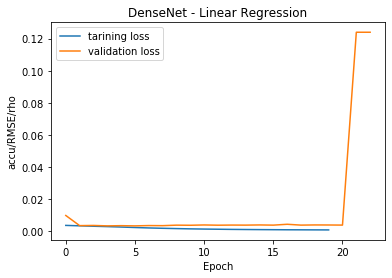

[0.38871944 0.41672084 0.38101905 0.44782239 0.39681984 0.42107105
 0.3959198  0.42617131 0.37771889 0.45487274 0.42442122 0.40502025
 0.42067103 0.42837142 0.42842142 0.40647032 0.34281714 0.4359218
 0.40082004 0.39781989 0.4040702  0.98274569 0.98249562]


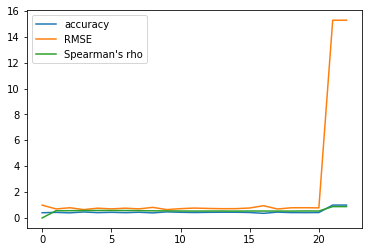

In [23]:
plt.figure()

plt.ylabel('accu/RMSE/rho')
plt.xlabel('Epoch')
plt.title('DenseNet - Linear Regression')

plt.plot(np.arange(len(training_stats['tarining_loss'])), training_stats['tarining_loss'], label='tarining loss')
plt.plot(np.arange(len(training_stats['validation_loss'])), training_stats['validation_loss'], label='validation loss')

plt.legend()
plt.show()

plt.plot(np.arange(len(training_stats['accuracy'])), training_stats['accuracy'], label='accuracy')
#plt.plot(np.arange(len(training_stats['classification'])), training_stats['classification'], label='')
plt.plot(np.arange(len(training_stats['RMSE'])), training_stats['RMSE'], label='RMSE')
plt.plot(np.arange(len(training_stats['spearmanr'])), [i[0] for i in training_stats['spearmanr']], label="Spearman's rho")

print(np.array(training_stats['accuracy']))
plt.legend()
plt.show()

In [43]:
with open('./Resource/Dense_Stock_LinearRegression_forPaper.pkl', 'wb') as fp:
        pickle.dump(training_stats, fp)

In [17]:
checkpoint = torch.load(open(checkpoint_save_dir + "\DenseNet_Baseline_10%_paper_E4A875_10.12.2020_16.38.06.tar", 'rb'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
training_stats = checkpoint['training_stats']

In [26]:
sample = AVADataset[25000]
print(i, sample['image'].size(), sample['rating'])
img = sample['image'][1]
img = np.array(img)
plt.imshow(img)

TypeError: 'type' object is not subscriptable

after input. size: torch.Size([2, 64, 56, 56])
after block1. size: torch.Size([2, 128, 28, 28])
after block2. size: torch.Size([2, 256, 14, 14])
after block3. size: torch.Size([2, 640, 7, 7])
after block4. size: torch.Size([2, 1664, 7, 7])
after pooling. size: torch.Size([2, 1664, 1, 1])

.resize_([batch_size, 1])
.resize_([batch_size, 1])